In [71]:
import warnings
warnings.filterwarnings("ignore")

import os
import json
from dotenv import load_dotenv
from typing import Optional, Dict, Any, Annotated, List, Literal

from langchain_groq import ChatGroq
from langgraph.graph import StateGraph, add_messages, END, START
from langchain.messages import HumanMessage, SystemMessage, AnyMessage
from langgraph.types import interrupt, Command
from db import upsert_application, update_analysis, set_decision, get_application

load_dotenv()

RUBRIC = {
    "required_skills": ["python", "sql"],
    "nice_to_have": ["langchain", "langgraph", "fastapi", "docker"],
    "weights": {
        "required_skills": 60,
        "nice_to_have": 30,
        "experience": 10,
    }
}

def _model():
    return ChatGroq(
        model="llama-3.1-8b-instant",
        api_key=os.getenv("GROQ_API_KEY"),
        temperature=0.3
    )

class State(StateGraph):
    messages: Annotated[List[AnyMessage], add_messages]
    application_id: str
    cv_text: str
    extracted: Dict[str, Any]
    score: int
    flags: List[str]
    needs_human: bool
    decision: Optional[str]
    reviewer_notes: str

def extract_CV(state: State) -> dict:
     # LLM chỉ trích xuất JSON theo schema; tránh thu thập thuộc tính nhạy cảm
    sys = SystemMessage(content=(
        "Bạn là hệ thống trích xuất CV cho mục đích screening.\n"
        "Chỉ trích xuất thông tin LIÊN QUAN CÔNG VIỆC.\n"
        "Không trích xuất/không suy đoán tuổi, giới tính, tôn giáo, chủng tộc, tình trạng hôn nhân.\n"
        "Chỉ trả về JSON thuần (không markdown), không nói hay nhận xét gì thêm:\n"
        "{"
        "\"name\": str|null, "
        "\"email\": str|null, "
        "\"years_experience\": number|null, "
        "\"skills\": [str], "
        "\"roles\": [str], "
        "\"projects\": [str], "
        "\"education\": str|null"
        "}\n"
        "Nếu thiếu thì để null hoặc []."
        "Lưu ý chỉ trả về dạng JSON thuần, không giải thích gì thêm."
    ))

    ai = _model().invoke([sys] + state['messages'])

    try:
        exacted=json.loads(ai.content)
    except Exception as e:
        print("Error parsing JSON:", e)
        exacted = {
            "name": None,
            "email": None,
            "years_experience": None,
            "skills": [],
            "roles": [],
            "projects": [],
            "education": None
        }
    return {
        "extracted": exacted,
        "messages": [ai]
    }

def score_application(state: State) -> dict:
    required_skills = RUBRIC["required_skills"]
    nice_to_have = RUBRIC["nice_to_have"]

    skills= [s.lower() for s in state['extracted'].get("skills", [])]
    req_hit=sum(1 for skill in required_skills if skill in skills)
    req_score= (req_hit / len(required_skills)) * RUBRIC["weights"]["required_skills"]    

    nice_hit=sum(1 for skill in nice_to_have if skill in skills)
    nice_score= (nice_hit / len(nice_to_have)) * RUBRIC["weights"]["nice_to_have"]

    years_exp = state['extracted'].get("years_experience", 0) or 0
    years_exp=float(years_exp)
    exp_score = 10 if years_exp >=2 else int((years_exp/2)*RUBRIC["weights"]["experience"])
    score= max(0, min(100, int(req_score + nice_score + exp_score)))
    return {
        "score": score
    }

def flags_node(state: State) -> dict:
    extracted=state['extracted']
    flags=[]
    skills= [s.lower() for s in extracted.get("skills", [])]

    missing_required = [skill for skill in RUBRIC["required_skills"] if skill not in skills]

    if missing_required:
        flags.append(f"Missing required skills: {', '.join(missing_required)}")
    
    if not extracted.get("email"):
        flags.append("Missing contact information")
    
    if len(extracted.get("roles", []))==0 and len(extracted.get("projects", []))==0:
        flags.append("Lacks detail on roles/projects")

    need_human=True # screening luôn yêu cầu human review (production-safe)
    return {
        "flags": flags,
        "needs_human": need_human
    }

def human_review(state: State) -> dict:
    payload={
        "application_id": state['application_id'],
        "score": state['score'],
        "flags": state['flags'],
        "extracted": state['extracted'],
        "recommendation": "Recommend for next round" if float(state['score']) >= 70 else "Do not recommend"
    }

    decision=interrupt(payload)
    approve=bool(decision.get("approve", False))
    final_decision=decision.get("decision", "Shortlist") if approve else "Rejected"
    edited=decision.get("edited_extracted")
    notes=decision.get("reviewer_notes", "")
    if isinstance(edited, dict):
        state['extracted']=edited
    
    return {
        "needs_human": not approve,
        "decision": final_decision if approve else "Rejected",
        "reviewer_notes": notes,
        "extracted": state['extracted']
    }

def persist_analysis_node(state: State) -> dict:
    update_analysis(
        application_id=state['application_id'],
        extracted=state['extracted'],
        score=state['score'],
        flags=state['flags'],
        recommendation=state['decision']
    )
    return {}

def finalize_decision_node(state: State) -> dict:
    decision=state.get("decision") or "Shortlist" if state['score'] >= 70 else "Rejected"
    set_decision(state['application_id'], decision, state.get("reviewer_notes", ""))
    return {}

def route_after_review(state: State) -> dict:
    return "finalize_decision_node" if not state.get("human_review", True) else END 

def upsert_node(state: State) -> dict:
    res=upsert_application(state['application_id'], state['cv_text'])
    return {
        "decision": res['decision']
    }

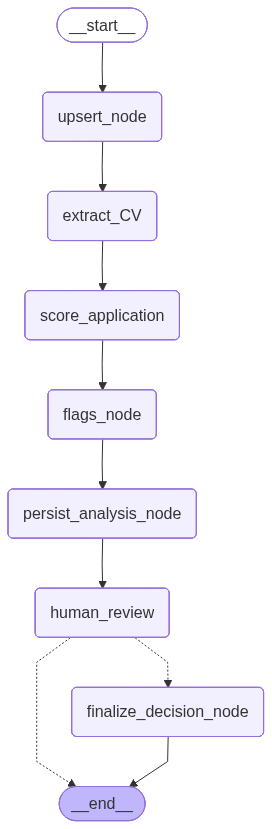

In [81]:
# Build graph

builder=StateGraph(State)
builder.add_node("extract_CV", extract_CV)
builder.add_node("score_application", score_application)
builder.add_node("flags_node", flags_node)
builder.add_node("human_review", human_review)
builder.add_node("persist_analysis_node", persist_analysis_node)
builder.add_node("finalize_decision_node", finalize_decision_node)
builder.add_node("upsert_node", upsert_node)

builder.add_edge(START, "upsert_node")
builder.add_edge("upsert_node", "extract_CV")
builder.add_edge("extract_CV", "score_application")
builder.add_edge("score_application", "flags_node")
builder.add_edge("flags_node", "persist_analysis_node")
builder.add_edge("persist_analysis_node", "human_review")
builder.add_conditional_edges("human_review", route_after_review, ["finalize_decision_node", END])
builder.add_edge("finalize_decision_node", END)


graph=builder.compile()
from IPython.display import display, Image
display(Image(graph.get_graph().draw_mermaid_png()))

In [64]:
from langchain.messages import HumanMessage

cv_text_1 = """
Nguyễn Văn A
Email: 
Kinh nghiệm: 3 năm Backend
Kỹ năng: Python, SQL, FastAPI, Docker, LangGraph
Dự án: Xây hệ thống chatbot nội bộ, API cho ticketing
"""

state_init_1 = {
    "messages": [HumanMessage(content=cv_text_1)],  # để trace (nếu bạn cần)
    "application_id": "app_001",
    "cv_text": cv_text_1,         # node extract thường đọc từ đây
    "extracted": {},              # sẽ được node extract ghi vào
    "score": 0,                   # sẽ được score_node cập nhật
    "flags": [],                  # sẽ được flags_node cập nhật
    "needs_human": True,          # flow review-safe
    "decision": None,             # sẽ có sau review
    "reviewer_notes": "",
}


In [65]:
extracted=extract_CV(state_init_1)
state_init_1["extracted"]=extracted['extracted']

In [66]:
flags=flags_node(state_init_1)
state_init_1['flags']=flags['flags']
print("Flags:", flags['flags'])

Flags: ['Missing contact information']


In [67]:
cv_score=score_application(state_init_1)
print(cv_score['score'])

92


In [68]:
state_init_1['score']=cv_score['score']

In [69]:
for x in state_init_1.keys():
    print(f"{x}: {state_init_1[x]}")
    print("---"*50)

messages: [HumanMessage(content='\nNguyễn Văn A\nEmail: \nKinh nghiệm: 3 năm Backend\nKỹ năng: Python, SQL, FastAPI, Docker, LangGraph\nDự án: Xây hệ thống chatbot nội bộ, API cho ticketing\n', additional_kwargs={}, response_metadata={})]
------------------------------------------------------------------------------------------------------------------------------------------------------
application_id: app_001
------------------------------------------------------------------------------------------------------------------------------------------------------
cv_text: 
Nguyễn Văn A
Email: 
Kinh nghiệm: 3 năm Backend
Kỹ năng: Python, SQL, FastAPI, Docker, LangGraph
Dự án: Xây hệ thống chatbot nội bộ, API cho ticketing

------------------------------------------------------------------------------------------------------------------------------------------------------
extracted: {'name': 'Nguyễn Văn A', 'email': None, 'years_experience': 3, 'skills': ['Python', 'SQL', 'FastAPI', 'Docker',

In [83]:
import os, json
from typing import List, Annotated, TypedDict, Optional, Literal, Dict, Any
from dotenv import load_dotenv

from langchain_groq import ChatGroq
from langchain.messages import SystemMessage, HumanMessage, AnyMessage
from langgraph.graph import StateGraph, START, END, add_messages
from langgraph.types import interrupt, Command
from langgraph.checkpoint.sqlite import SqliteSaver

from db import upsert_application, update_analysis, set_decision, get_application

load_dotenv()

# ===== Job rubric (basic) =====
# production: tách thành config theo job_id / YAML / DB
RUBRIC = {
    "required_skills": ["python", "sql"],
    "nice_to_have": ["langchain", "langgraph", "fastapi", "docker"],
    "weights": {
        "required_skills": 60,
        "nice_to_have": 30,
        "experience": 10,
    }
}

def _model():
    return ChatGroq(
        model=os.getenv("GROQ_MODEL", "llama-3.1-8b-instant"),
        api_key=os.getenv("GROQ_API_KEY"),
        temperature=0.2,
    )

class State(TypedDict):
    messages: Annotated[List[AnyMessage], add_messages]
    application_id: str
    cv_text: str
    extracted: Dict[str, Any]
    score: int
    flags: List[str]
    needs_human: bool
    decision: Optional[str]
    reviewer_notes: str

# ----- Nodes -----
def upsert_node(state: State) -> dict:
    # Idempotent side-effect (OK trước interrupt)
    res = upsert_application(state["application_id"], state["cv_text"])
    # Nếu đã có decision final, có thể short-circuit (tuỳ bạn)
    return {"decision": res.get("decision")}

def extract_cv_json(state: State) -> dict:
    # LLM chỉ trích xuất JSON theo schema; tránh thu thập thuộc tính nhạy cảm
    sys = SystemMessage(content=(
        "Bạn là hệ thống trích xuất CV cho mục đích screening.\n"
        "Chỉ trích xuất thông tin LIÊN QUAN CÔNG VIỆC.\n"
        "Không trích xuất/không suy đoán tuổi, giới tính, tôn giáo, chủng tộc, tình trạng hôn nhân.\n"
        "Trả về JSON thuần (không markdown), schema:\n"
        "{"
        "\"name\": str|null, "
        "\"email\": str|null, "
        "\"years_experience\": number|null, "
        "\"skills\": [str], "
        "\"roles\": [str], "
        "\"projects\": [str], "
        "\"education\": str|null"
        "}\n"
        "Nếu thiếu thì để null hoặc []."
    ))
    user = HumanMessage(content=state["cv_text"])
    ai = _model().invoke([sys, user])

    try:
        extracted = json.loads(ai.content)
    except:
        extracted = {
            "name": None, "email": None, "years_experience": None,
            "skills": [], "roles": [], "projects": [], "education": None
        }

    return {"extracted": extracted, "messages": [ai]}

def score_node(state: State) -> dict:
    skills = [s.lower().strip() for s in (state["extracted"].get("skills") or [])]
    req = RUBRIC["required_skills"]
    nice = RUBRIC["nice_to_have"]

    req_hit = sum(1 for r in req if r in skills)
    nice_hit = sum(1 for n in nice if n in skills)

    req_score = int(RUBRIC["weights"]["required_skills"] * (req_hit / max(len(req), 1)))
    nice_score = int(RUBRIC["weights"]["nice_to_have"] * (min(nice_hit, len(nice)) / max(len(nice), 1)))

    yoe = state["extracted"].get("years_experience")
    exp_score = 0
    try:
        y = float(yoe)
        exp_score = 10 if y >= 2 else int(10 * (y / 2))
    except:
        exp_score = 0

    score = max(0, min(100, req_score + nice_score + exp_score))
    return {"score": score}

def flags_node(state: State) -> dict:
    flags = []
    extracted = state["extracted"]
    skills = [s.lower().strip() for s in (extracted.get("skills") or [])]

    missing_required = [r for r in RUBRIC["required_skills"] if r not in skills]
    if missing_required:
        flags.append(f"Missing required skills: {', '.join(missing_required)}")

    if not extracted.get("email"):
        flags.append("Missing email")

    # Confidence-like heuristic: ít thông tin
    if len(extracted.get("roles") or []) == 0 and len(extracted.get("projects") or []) == 0:
        flags.append("Sparse CV: no roles/projects detected")

    needs_human = True  # screening luôn yêu cầu human review (production-safe)
    return {"flags": flags, "needs_human": needs_human}

def persist_analysis_node(state: State) -> dict:
    # Idempotent update: ghi extracted/score/flags vào DB (OK trước interrupt)
    update_analysis(state["application_id"], state["extracted"], state["score"], state["flags"])
    return {}

def human_review_node(state: State) -> dict:
    payload = {
        "application_id": state["application_id"],
        "score": state["score"],
        "flags": state["flags"],
        "extracted": state["extracted"],
        "recommendation": "shortlist" if state["score"] >= 70 and len(state["flags"]) <= 1 else "review"
    }
    decision = interrupt(payload)
    # decision from resume: {"approve": bool, "decision": "shortlist|reject", "edited_extracted": {...}?, "notes": str?}
    approve = bool(decision.get("approve", False))
    final_decision = decision.get("decision", "reject" if not approve else "shortlist")
    edited = decision.get("edited_extracted")
    notes = decision.get("notes", "")

    # nếu reviewer sửa extracted thì cập nhật lại score/flags? (nâng cao hơn nữa)
    if isinstance(edited, dict):
        state["extracted"] = edited  # quick patch

    return {
        "needs_human": (not approve),
        "decision": final_decision if approve else "reject",
        "reviewer_notes": notes,
        "extracted": state["extracted"],
    }

def finalize_node(state: State) -> dict:
    # Side-effect cuối: set decision
    decision = state.get("decision") or ("shortlist" if state["score"] >= 70 else "reject")
    set_decision(state["application_id"], decision, state.get("reviewer_notes", ""))
    return {}

def route_after_review(state: State) -> Literal["finalize_node", END]:
    return "finalize_node" if not state.get("needs_human", True) else END

# ----- Build graph -----
builder = StateGraph(State)
builder.add_node("upsert", upsert_node)
builder.add_node("extract", extract_cv_json)
builder.add_node("score", score_node)
builder.add_node("flags", flags_node)
builder.add_node("persist", persist_analysis_node)
builder.add_node("human_review", human_review_node)
builder.add_node("finalize_node", finalize_node)

builder.add_edge(START, "upsert")
builder.add_edge("upsert", "extract")
builder.add_edge("extract", "score")
builder.add_edge("score", "flags")
builder.add_edge("flags", "persist")
builder.add_edge("persist", "human_review")
builder.add_conditional_edges("human_review", route_after_review, ["finalize_node", END])
builder.add_edge("finalize_node", END)

import sqlite3

conn = sqlite3.connect("checkpoints.sqlite", check_same_thread=False)  # có thể thêm check_same_thread=False nếu dùng thread
checkpointer = SqliteSaver(conn)

graph = builder.compile(checkpointer=checkpointer)
from IPython.display import display, Image
display(Image(graph.get_graph().draw_mermaid_png()))


ValueError: Failed to reach https://mermaid.ink API while trying to render your graph after 1 retries. To resolve this issue:
1. Check your internet connection and try again
2. Try with higher retry settings: `draw_mermaid_png(..., max_retries=5, retry_delay=2.0)`
3. Use the Pyppeteer rendering method which will render your graph locally in a browser: `draw_mermaid_png(..., draw_method=MermaidDrawMethod.PYPPETEER)`